<h1><strong><u>Assignment 6 (SOM/MLP)</u></strong></h1>

<h2>Steps to take when looking into this outside of school.</h2>
<ol>
<li>Make a pipeline for the preprocessing steps</li>
<li>Use that pipeline for validation curve for MLP</li>
<li>Apply cross-validation for final MLP</li>
</ol>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import accuracy_score, silhouette_score, pair_confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split, validation_curve
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn_som.som import SOM

plt.style.use('dark_background')

%run DataCleaningFunctions.ipynb

<h2><strong><u>Data Preprocessing</u></strong></h2>

<h3><u>Data Loading</u></h3>

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/cdavidshaffer/CPSC4970-AI/master/data/penguins.csv")
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   species            344 non-null    object
 1   island             344 non-null    object
 2   culmen_length_mm   344 non-null    object
 3   culmen_depth_mm    344 non-null    object
 4   flipper_length_mm  344 non-null    object
 5   body_mass_g        344 non-null    object
 6   sex                344 non-null    object
dtypes: object(7)
memory usage: 18.9+ KB


,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,?,?,?,?,?
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE
6,Adelie,Torgersen,38.9,17.8,181.0,3625.0,FEMALE
7,Adelie,Torgersen,39.2,19.6,195.0,4675.0,MALE
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,?
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,?


<h3><u>Data Cleaning</u></h3>

In [4]:
# check text column unique values
textual_columns = ['species', 'island', 'sex']
print_unique_values(textual_columns, data)

species Column: ['Adelie' 'Chinstrap' 'Gentoo']
island Column: ['Torgersen' 'Biscoe' 'Dream']
sex Column: ['MALE' 'FEMALE' '?' '_']


In [5]:
# Replace invalid text entries
replace_characters = ['?', '_']

for char in replace_characters:
    replace_data_values(data, 'sex', char, None)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   species            344 non-null    object
 1   island             344 non-null    object
 2   culmen_length_mm   344 non-null    object
 3   culmen_depth_mm    344 non-null    object
 4   flipper_length_mm  344 non-null    object
 5   body_mass_g        344 non-null    object
 6   sex                333 non-null    object
dtypes: object(7)
memory usage: 18.9+ KB


/var/folders/0_/nmh5w64x3q5_ffwfkr35sscw0000gn/T/ipykernel_9050/2898130538.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column_name].replace(to_replace, value, inplace=True)


In [6]:
# convert text columns to string type
for i in textual_columns:
    data[i] = data[i].astype('string')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   species            344 non-null    string
 1   island             344 non-null    string
 2   culmen_length_mm   344 non-null    object
 3   culmen_depth_mm    344 non-null    object
 4   flipper_length_mm  344 non-null    object
 5   body_mass_g        344 non-null    object
 6   sex                333 non-null    string
dtypes: object(4), string(3)
memory usage: 18.9+ KB


In [7]:
# clean numerical columns from non-numerical values
numerical_columns = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
check_numerical_column_errors(data, numerical_columns)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    string 
 1   island             344 non-null    string 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    string 
dtypes: float64(4), string(3)
memory usage: 18.9 KB


In [8]:
# Drop all rows with missing values
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 333 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            333 non-null    string 
 1   island             333 non-null    string 
 2   culmen_length_mm   333 non-null    float64
 3   culmen_depth_mm    333 non-null    float64
 4   flipper_length_mm  333 non-null    float64
 5   body_mass_g        333 non-null    float64
 6   sex                333 non-null    string 
dtypes: float64(4), string(3)
memory usage: 20.8 KB


In [9]:
display(data)

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE
...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,FEMALE
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,FEMALE
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,MALE
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,FEMALE


In [10]:
#Display message counts
adelie = data[(data['species'] == 'Adelie')]
chinstrap = data[(data['species'] == 'Chinstrap')]
gentoo = data[(data['species'] == 'Gentoo')]

adelie_count = adelie.value_counts().sum()
chinstrap_count = chinstrap.value_counts().sum()
gentoo_count = gentoo.value_counts().sum()

total = adelie_count + chinstrap_count + gentoo_count


adelie_fraction = adelie_count / total
chinstrap_fraction = chinstrap_count / total
gentoo_fraction = gentoo_count / total

print("Adelie Count: ", adelie_count)
print("Chinstrap Count: ", chinstrap_count)
print("Gentoo Count: ", gentoo_count)

print("Fraction of Adelie: {:.2f}%".format(adelie_fraction * 100))
print("Fraction of Chinstrap: {:.2f}%".format(chinstrap_fraction * 100))
print("Fraction of Gentoo: {:.2f}%".format(gentoo_fraction * 100))

Adelie Count:  146
Chinstrap Count:  68
Gentoo Count:  119
Fraction of Adelie: 43.84%
Fraction of Chinstrap: 20.42%
Fraction of Gentoo: 35.74%


In [11]:
# checked data again after cleaning

# data.to_csv("penguins.csv", index=False, header=data.columns.tolist())

<h3><u>Data Preparation</u></h3>

In [13]:
X = data.drop("species", axis=1)
y = data["species"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
display(X_train.shape) 
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(266, 6)

(67, 6)

(266,)

(67,)

In [43]:
# separate numerical and non-numerical data
X_train_nonnumerical = X_train.drop(columns=numerical_columns)
X_test_nonnumerical = X_test.drop(columns=numerical_columns)
display(X_train_nonnumerical.describe())
display(X_test_nonnumerical.describe())

X_train_numerical = X_train[numerical_columns]
X_test_numerical = X_test[numerical_columns]
display(X_train_numerical.describe())
display(X_test_numerical.describe())

,island,sex
count,266,266
unique,3,2
top,Biscoe,MALE
freq,130,138


,island,sex
count,67,67
unique,3,2
top,Biscoe,FEMALE
freq,33,37


,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,266.000000,266.000000,266.00000,266.000000
mean,44.103008,17.161278,201.00000,4214.755639
std,5.404917,1.980538,13.91592,807.921183
min,32.100000,13.100000,172.00000,2700.000000
25%,39.600000,15.525000,190.00000,3550.000000
50%,45.100000,17.300000,197.00000,4050.000000
75%,48.575000,18.700000,213.00000,4800.000000
max,59.600000,21.500000,231.00000,6300.000000


,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,67.000000,67.000000,67.000000,67.000000
mean,43.555224,17.179104,200.835821,4176.492537
std,5.735807,1.938332,14.511852,799.678920
min,34.600000,13.300000,178.000000,2900.000000
25%,38.400000,15.900000,190.000000,3550.000000
50%,43.300000,17.300000,196.000000,3950.000000
75%,48.800000,18.600000,212.500000,4700.000000
max,58.000000,21.100000,230.000000,5950.000000


<h3><u>Feature Engineering (SOM)</u></h3>

In [ ]:
som = SOM(m=5, n=5, dim=X_train_numerical.shape[1], random_state=0)
som.fit(X_train_numerical.values)
som_train_predictions = som.predict(X_train_numerical.values)
som_test_predictions = som.predict(X_test_numerical.values)
print(som_train_predictions)
print(som_test_predictions)

[14 16  3 17 23  9 19  8 18 23  1  6  4  5 18 15  6  4  8 23  8 13 10  4
  4 24 23 24 10 14 24 12  7 15  9 14  0 13  6  4  4  5  6 21 13 17  6 18
  6 16  2 22 10 23 16  8  0 17  8 21 22 18  0 21 18  0  6 21 21  4  7  8
  6  5  9 10 14 15  8  0  4  9 19  1 13 23 19  9 24 19 16 15 15 23  4  8
  8  5  9 14  7  4 15  5 17  4 16 14  4 13 15 16  0 14 18 14  4 18 20 14
  5  9 23 13 18 23  6 24 13 21 23 16  5 14 24  9 17 14  4 16 17 24 10 18
  3 23 21 23  4  5  9  6  3 14  3  6 10  4  3  1 14  7 21 23 18 12  6 24
  9  8  5  8 16 13 16  3  7  3  0 21 22  8 16 14  9  4 21 21  4  5 10 17
  0  2 17 13  8 19 19 14 19  0 12 14 19  4  4 18  5 24  7  4  6  2 13  6
 17  6 17  5 14  8 19 20  3 13 16 16  2  0  4 10  4  9 21 22  6  5  9  0
 17 20 21  8  3 22 11  4 19  3  4  8  5 15 23 22 19 13 18  3 17 22 23 15
  8 15]
[15  8 24  6 24 14  4  0  1 23 14 19 13  5 19 10 21  5 17 19 12  6  4 24
  0 21  9 14  6  4 21  4 19 22  4 13 17 23  5 21 16  5 10 23 16 22  3 18
 23  8  6  4 14  0 23  3 15 19 23 12  4  4 

In [47]:
X_train_nonnumerical_som = pd.DataFrame(np.append(X_train_nonnumerical, som_train_predictions.reshape(-1, 1), axis=1), columns=X_train_nonnumerical.columns.tolist() + ['SOM Category'])
X_test_nonnumerical_som = pd.DataFrame(np.append(X_test_nonnumerical, som_test_predictions.reshape(-1, 1), axis=1), columns=X_train_nonnumerical.columns.tolist() + ['SOM Category'])


display(X_train_nonnumerical_som.shape)
display(X_test_nonnumerical_som.shape)
display(X_train_nonnumerical_som.columns.tolist())
display(X_test_nonnumerical_som.columns.tolist())
display(X_train_nonnumerical_som.head(5))
display(X_test_nonnumerical_som.head(5))
preprocessor = make_column_transformer(
    (OneHotEncoder(sparse_output=False), X_train_nonnumerical_som.columns.tolist()),
    remainder='passthrough'
)

X_train_processed = preprocessor.fit_transform(X_train_nonnumerical_som)
X_train_df = pd.DataFrame(data=X_train_processed, columns=preprocessor.get_feature_names_out())
X_test_processed = preprocessor.fit_transform(X_test_nonnumerical_som)
X_test_df = pd.DataFrame(data=X_test_processed, columns=preprocessor.get_feature_names_out())
display(X_train_processed.shape)
display(X_test_processed.shape)



display(X_train_df.head(10))
display(X_test_df.head(10))
display(y_train.head(10))

(266, 3)

(67, 3)

['island', 'sex', 'SOM Category']

['island', 'sex', 'SOM Category']

,island,sex,SOM Category
0,Biscoe,FEMALE,14
1,Dream,FEMALE,16
2,Biscoe,MALE,3
3,Biscoe,FEMALE,17
4,Biscoe,MALE,23


,island,sex,SOM Category
0,Dream,FEMALE,15
1,Biscoe,FEMALE,8
2,Torgersen,MALE,24
3,Dream,FEMALE,6
4,Biscoe,MALE,24


(266, 30)

(67, 27)

,onehotencoder__island_Biscoe,onehotencoder__island_Dream,onehotencoder__island_Torgersen,onehotencoder__sex_FEMALE,onehotencoder__sex_MALE,onehotencoder__SOM Category_0,onehotencoder__SOM Category_1,onehotencoder__SOM Category_2,onehotencoder__SOM Category_3,onehotencoder__SOM Category_4,...,onehotencoder__SOM Category_15,onehotencoder__SOM Category_16,onehotencoder__SOM Category_17,onehotencoder__SOM Category_18,onehotencoder__SOM Category_19,onehotencoder__SOM Category_20,onehotencoder__SOM Category_21,onehotencoder__SOM Category_22,onehotencoder__SOM Category_23,onehotencoder__SOM Category_24
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


,onehotencoder__island_Biscoe,onehotencoder__island_Dream,onehotencoder__island_Torgersen,onehotencoder__sex_FEMALE,onehotencoder__sex_MALE,onehotencoder__SOM Category_0,onehotencoder__SOM Category_1,onehotencoder__SOM Category_2,onehotencoder__SOM Category_3,onehotencoder__SOM Category_4,...,onehotencoder__SOM Category_14,onehotencoder__SOM Category_15,onehotencoder__SOM Category_16,onehotencoder__SOM Category_17,onehotencoder__SOM Category_18,onehotencoder__SOM Category_19,onehotencoder__SOM Category_21,onehotencoder__SOM Category_22,onehotencoder__SOM Category_23,onehotencoder__SOM Category_24
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


230       Gentoo
84        Adelie
303       Gentoo
22        Adelie
29        Adelie
257       Gentoo
334       Gentoo
244       Gentoo
183    Chinstrap
88        Adelie
Name: species, dtype: string

<h2><strong><u>MLP Model Selection</u></strong></h2>

<h3><u>Validation Curves</u></h3>

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END .clf__alpha=0.0001;, score=(train=0.901, test=0.759) total time=   0.2s
[CV] END ....clf__alpha=0.1;, score=(train=0.887, test=0.741) total time=   0.2s
[CV] END ..clf__alpha=0.001;, score=(train=0.901, test=0.741) total time=   0.2s
[CV] END ...clf__alpha=0.01;, score=(train=0.901, test=0.722) total time=   0.2s
[CV] END ......clf__alpha=1;, score=(train=0.811, test=0.648) total time=   0.2s
[CV] END .clf__alpha=0.0001;, score=(train=0.859, test=0.849) total time=   0.2s
[CV] END ..clf__alpha=0.001;, score=(train=0.840, test=0.887) total time=   0.2s
[CV] END ...clf__alpha=0.01;, score=(train=0.864, test=0.868) total time=   0.2s
[CV] END ......clf__alpha=1;, score=(train=0.831, test=0.717) total time=   0.1s
[CV] END .clf__alpha=0.0001;, score=(train=0.892, test=0.660) total time=   0.2s
[CV] END ..clf__alpha=0.001;, score=(train=0.887, test=0.698) total time=   0.2s


[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:    0.3s remaining:    0.6s


[CV] END ....clf__alpha=0.1;, score=(train=0.840, test=0.868) total time=   0.2s
[CV] END ...clf__alpha=0.01;, score=(train=0.897, test=0.660) total time=   0.2s
[CV] END ......clf__alpha=1;, score=(train=0.798, test=0.774) total time=   0.2s
[CV] END ....clf__alpha=0.1;, score=(train=0.887, test=0.717) total time=   0.2s
[CV] END .clf__alpha=0.0001;, score=(train=0.873, test=0.774) total time=   0.2s
[CV] END .clf__alpha=0.0001;, score=(train=0.883, test=0.755) total time=   0.1s
[CV] END ....clf__alpha=0.1;, score=(train=0.859, test=0.774) total time=   0.2s
[CV] END ..clf__alpha=0.001;, score=(train=0.873, test=0.811) total time=   0.2s
[CV] END ......clf__alpha=1;, score=(train=0.793, test=0.736) total time=   0.2s
[CV] END ...clf__alpha=0.01;, score=(train=0.859, test=0.755) total time=   0.2s
[CV] END ..clf__alpha=0.001;, score=(train=0.883, test=0.755) total time=   0.2s
[CV] END ...clf__alpha=0.01;, score=(train=0.873, test=0.736) total time=   0.2s
[CV] END ......clf__alpha=1;

[Parallel(n_jobs=-1)]: Done  17 out of  25 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.7s finished


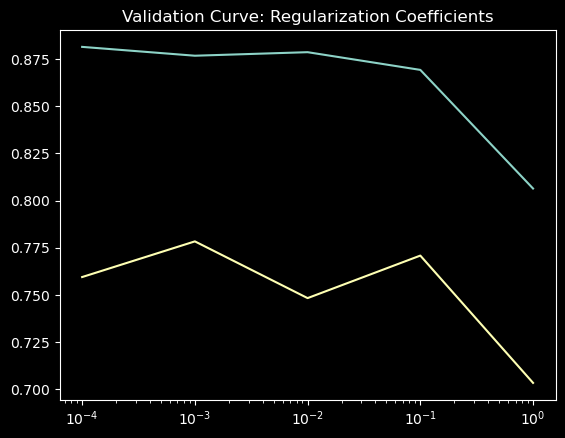

Exception ignored in: <function ResourceTracker.__del__ at 0x1067ddbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10290dbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x102c35bc0>
Traceback (most recent call last

In [51]:
# Validation Curve for Testing Regularization Coefficient Ranges

pipeline = Pipeline(
    [
        ("clf", MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000)),
    ]
)
alphas = [0.0001, 0.001, 0.01, 0.1, 1]
train_scores, validation_scores = validation_curve(pipeline, X_train_df, y_train, cv=5, scoring='accuracy',
                                                   param_name="clf__alpha",
                                                   param_range=alphas,
                                                   verbose=3,
                                                   n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.title("Validation Curve: Regularization Coefficients")
plt.semilogx(alphas, train_scores_mean)
plt.semilogx(alphas, validation_scores_mean)

<h4><u>Findings From 'Regularization Coefficients' Validation Curve</u></h4>
The shape of this plot suggest that increasing the regularization coefficient leads the model to underfit. This suggests that the regularization coefficient should probably remain minimal.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END clf__hidden_layer_sizes=(200,);, score=(train=0.896, test=0.759) total time=   0.2s
[CV] END clf__hidden_layer_sizes=(300,);, score=(train=0.896, test=0.741) total time=   0.2s
[CV] END clf__hidden_layer_sizes=(100,);, score=(train=0.896, test=0.778) total time=   0.1s
[CV] END clf__hidden_layer_sizes=(100,);, score=(train=0.864, test=0.868) total time=   0.2s
[CV] END clf__hidden_layer_sizes=(400,);, score=(train=0.901, test=0.759) total time=   0.2s
[CV] END clf__hidden_layer_sizes=(200,);, score=(train=0.859, test=0.868) total time=   0.2s
[CV] END clf__hidden_layer_sizes=(300,);, score=(train=0.869, test=0.868) total time=   0.2s
[CV] END clf__hidden_layer_sizes=(500,);, score=(train=0.887, test=0.722) total time=   0.3s
[CV] END clf__hidden_layer_sizes=(100,);, score=(train=0.897, test=0.679) total time=   0.1s


[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:    2.5s remaining:    5.4s


[CV] END clf__hidden_layer_sizes=(300,);, score=(train=0.897, test=0.679) total time=   0.2s
[CV] END clf__hidden_layer_sizes=(100,);, score=(train=0.878, test=0.811) total time=   0.1s
[CV] END clf__hidden_layer_sizes=(200,);, score=(train=0.887, test=0.755) total time=   0.2s
[CV] END clf__hidden_layer_sizes=(400,);, score=(train=0.864, test=0.887) total time=   0.3s
[CV] END clf__hidden_layer_sizes=(500,);, score=(train=0.869, test=0.849) total time=   0.3s
[CV] END clf__hidden_layer_sizes=(500,);, score=(train=0.892, test=0.717) total time=   0.2s
[CV] END clf__hidden_layer_sizes=(400,);, score=(train=0.901, test=0.717) total time=   0.3s
[CV] END clf__hidden_layer_sizes=(200,);, score=(train=0.878, test=0.792) total time=   0.2s
[CV] END clf__hidden_layer_sizes=(100,);, score=(train=0.878, test=0.736) total time=   0.1s


[Parallel(n_jobs=-1)]: Done  17 out of  25 | elapsed:    2.8s remaining:    1.3s


[CV] END clf__hidden_layer_sizes=(300,);, score=(train=0.873, test=0.755) total time=   0.3s
[CV] END clf__hidden_layer_sizes=(300,);, score=(train=0.883, test=0.736) total time=   0.2s
[CV] END clf__hidden_layer_sizes=(200,);, score=(train=0.883, test=0.774) total time=   0.3s
[CV] END clf__hidden_layer_sizes=(400,);, score=(train=0.883, test=0.755) total time=   0.2s
[CV] END clf__hidden_layer_sizes=(500,);, score=(train=0.873, test=0.811) total time=   0.3s
[CV] END clf__hidden_layer_sizes=(400,);, score=(train=0.873, test=0.774) total time=   0.4s
[CV] END clf__hidden_layer_sizes=(500,);, score=(train=0.883, test=0.755) total time=   0.3s


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    3.1s finished


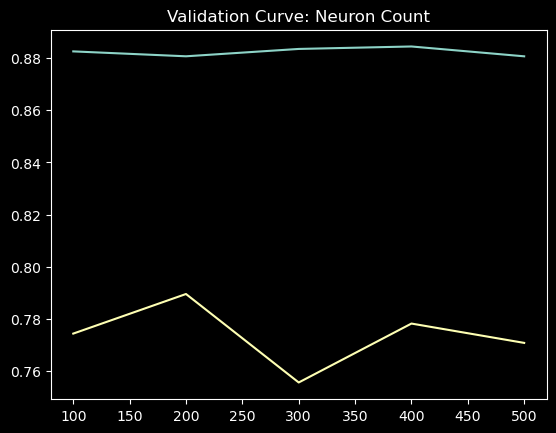

In [52]:
# Validation Curve for Testing Effect of Neuron Count

pipeline = Pipeline(
    [
        ("clf", MLPClassifier(max_iter=1000)),
    ]
)

hidden_layers = [(100,), (200,), (300,), (400,), (500,)]
neurons = list(range(100, 501, 100))
train_scores, validation_scores = validation_curve(pipeline, X_train_df, y_train, cv=5, scoring='accuracy',
                                                   param_name="clf__hidden_layer_sizes",
                                                   param_range=hidden_layers,
                                                   verbose=3,
                                                   n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.title("Validation Curve: Neuron Count")
plt.plot(neurons, train_scores_mean)
plt.plot(neurons, validation_scores_mean)

<h4><u>Findings From 'Neuron Count' Validation Curve</u></h4>
The shape of this plot suggest that increasing will not have much effect on the generalization of the model and would likely lead to an overfitting trend. I will test how does increasing the hidden layers affect the generalization of the algorithm.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END clf__hidden_layer_sizes=(60, 4);, score=(train=0.887, test=0.685) total time=   0.1s
[CV] END clf__hidden_layer_sizes=(60, 5);, score=(train=0.892, test=0.722) total time=   0.1s
[CV] END clf__hidden_layer_sizes=(60,);, score=(train=0.901, test=0.741) total time=   0.2s
[CV] END clf__hidden_layer_sizes=(60, 3);, score=(train=0.901, test=0.741) total time=   0.2s
[CV] END clf__hidden_layer_sizes=(60, 6);, score=(train=0.901, test=0.741) total time=   0.2s
[CV] END clf__hidden_layer_sizes=(60, 7);, score=(train=0.892, test=0.704) total time=   0.2s
[CV] END clf__hidden_layer_sizes=(60, 8);, score=(train=0.901, test=0.759) total time=   0.2s
[CV] END clf__hidden_layer_sizes=(60, 9);, score=(train=0.901, test=0.741) total time=   0.1s
[CV] END clf__hidden_layer_sizes=(60, 10);, score=(train=0.896, test=0.759) total time=   0.2s
[CV] END clf__hidden_layer_sizes=(60,);, score=(train=0.864, test=0.811) total time=   0.2s
[CV] END clf__hidden_layer_sizes=(60, 4);, score=(train=0.864, 

[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    0.5s remaining:    0.9s


[CV] END clf__hidden_layer_sizes=(60, 3);, score=(train=0.892, test=0.698) total time=   0.2s
[CV] END clf__hidden_layer_sizes=(60, 8);, score=(train=0.897, test=0.660) total time=   0.1s
[CV] END clf__hidden_layer_sizes=(60, 4);, score=(train=0.901, test=0.642) total time=   0.2s
[CV] END clf__hidden_layer_sizes=(60, 2);, score=(train=0.887, test=0.736) total time=   0.2s
[CV] END clf__hidden_layer_sizes=(60, 7);, score=(train=0.901, test=0.698) total time=   0.2s
[CV] END clf__hidden_layer_sizes=(60, 6);, score=(train=0.892, test=0.679) total time=   0.2s
[CV] END clf__hidden_layer_sizes=(60, 10);, score=(train=0.901, test=0.660) total time=   0.1s
[CV] END clf__hidden_layer_sizes=(60,);, score=(train=0.869, test=0.792) total time=   0.1s
[CV] END clf__hidden_layer_sizes=(60, 9);, score=(train=0.901, test=0.717) total time=   0.2s
[CV] END clf__hidden_layer_sizes=(60, 5);, score=(train=0.878, test=0.792) total time=   0.1s
[CV] END clf__hidden_layer_sizes=(60, 7);, score=(train=0.878

[Parallel(n_jobs=-1)]: Done  34 out of  50 | elapsed:    0.9s remaining:    0.4s


[CV] END clf__hidden_layer_sizes=(60, 5);, score=(train=0.883, test=0.774) total time=   0.1s
[CV] END clf__hidden_layer_sizes=(60, 4);, score=(train=0.883, test=0.755) total time=   0.2s
[CV] END clf__hidden_layer_sizes=(60, 6);, score=(train=0.878, test=0.736) total time=   0.2s
[CV] END clf__hidden_layer_sizes=(60, 7);, score=(train=0.883, test=0.755) total time=   0.2s
[CV] END clf__hidden_layer_sizes=(60, 9);, score=(train=0.869, test=0.736) total time=   0.1s
[CV] END clf__hidden_layer_sizes=(60, 2);, score=(train=0.878, test=0.755) total time=   0.3s
[CV] END clf__hidden_layer_sizes=(60, 8);, score=(train=0.878, test=0.755) total time=   0.2s
[CV] END clf__hidden_layer_sizes=(60, 3);, score=(train=0.878, test=0.774) total time=   0.3s
[CV] END clf__hidden_layer_sizes=(60, 10);, score=(train=0.883, test=0.774) total time=   0.1s
[CV] END clf__hidden_layer_sizes=(60, 2);, score=(train=0.859, test=0.717) total time=   0.6s


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished


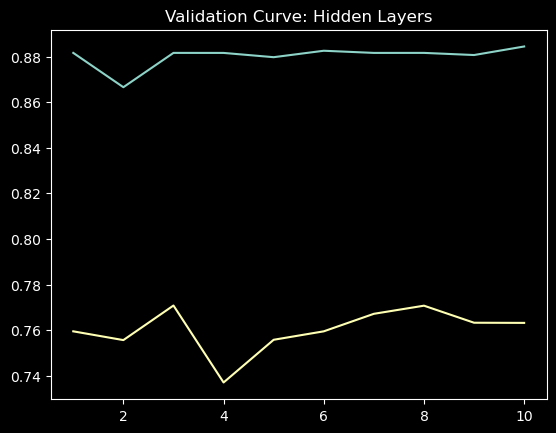

In [49]:
# Validation Curve for Testing Effect of Adding Hidden Layers

pipeline = Pipeline(
    [
        ("clf", MLPClassifier(max_iter=2000)),
    ]
)

hidden_layers_sizes = [(60,), (60,2), (60,3), (60,4), (60,5), (60,6), (60,7), (60,8), (60,9), (60,10)]
hidden_layers = list(range(1,11))
train_scores, validation_scores = validation_curve(pipeline, X_train_df, y_train, cv=5, scoring='accuracy',
                                                   param_name="clf__hidden_layer_sizes",
                                                   param_range=hidden_layers_sizes,
                                                   verbose=3,
                                                   n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.title("Validation Curve: Hidden Layers")
plt.plot(hidden_layers, train_scores_mean)
plt.plot(hidden_layers, validation_scores_mean)

<h4><u>Findings From 'Hidden Layers' Validation Curve</u></h4>
The performance of the mode still remains mostly the same. The gap between the train and validation scores are still very large with no sign that they will converge towards each other.

In [54]:
pipeline = Pipeline(
    [
        ("clf", MLPClassifier(max_iter=5000)),
    ]
)

cv_params = {
    'clf__hidden_layer_sizes': [(180, 3), (200, 3), (220, 3), (240, 3)],
}
grid_search = GridSearchCV(pipeline, cv_params, cv=5, n_jobs=-1, scoring='accuracy', verbose=3)
grid_search.fit(X_train_df, y_train)
best_model = grid_search.best_estimator_
display(best_model)
y_train_pred = best_model.predict(X_train_df)
y_test_pred = best_model.predict(X_test_df)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Training Accuracy after Hyperparameter Tuning: {train_accuracy:.4f}")
print(f"Testing Accuracy after Hyperparameter Tuning: {test_accuracy:.4f}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ..clf__hidden_layer_sizes=(180, 3);, score=0.704 total time=   0.3s
[CV 4/5] END ..clf__hidden_layer_sizes=(180, 3);, score=0.755 total time=   0.3s
[CV 2/5] END ..clf__hidden_layer_sizes=(200, 3);, score=0.830 total time=   0.2s
[CV 3/5] END ..clf__hidden_layer_sizes=(180, 3);, score=0.698 total time=   0.3s
[CV 1/5] END ..clf__hidden_layer_sizes=(200, 3);, score=0.796 total time=   0.3s
[CV 3/5] END ..clf__hidden_layer_sizes=(200, 3);, score=0.717 total time=   0.3s
[CV 1/5] END ..clf__hidden_layer_sizes=(220, 3);, score=0.741 total time=   0.2s
[CV 3/5] END ..clf__hidden_layer_sizes=(220, 3);, score=0.717 total time=   0.3s
[CV 4/5] END ..clf__hidden_layer_sizes=(200, 3);, score=0.792 total time=   0.3s
[CV 2/5] END ..clf__hidden_layer_sizes=(180, 3);, score=0.906 total time=   0.7s
[CV 5/5] END ..clf__hidden_layer_sizes=(180, 3);, score=0.717 total time=   0.7s
[CV 5/5] END ..clf__hidden_layer_sizes=(220, 3);,

Pipeline(steps=[('clf',
                 MLPClassifier(hidden_layer_sizes=(200, 3), max_iter=5000))])

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- onehotencoder__SOM Category_11
- onehotencoder__SOM Category_20
- onehotencoder__SOM Category_7


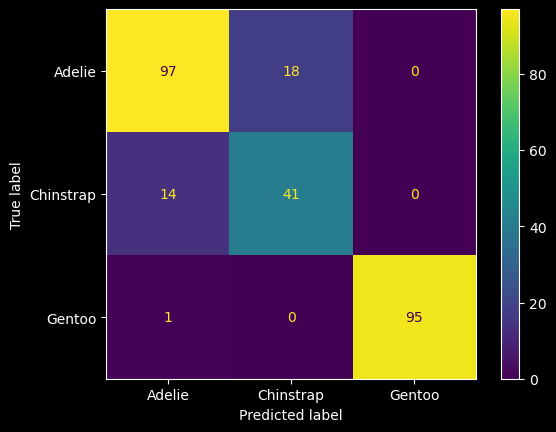

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)

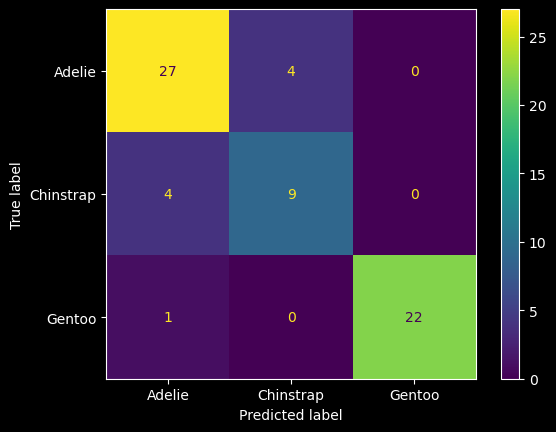

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)